In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, Xo=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize=18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if Xo:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        if y_lim: ax2.set_ylim(y_lim)
        marker_style = dict(color=colors[3], linewidth=3, linestyle='-', fillstyle='full',
                            marker='o', markersize=10, markerfacecolor='white', markeredgewidth=2)
        ax2.plot(scaling[x_axis], scaling['Xo'], label='Xo absolute timing', **marker_style)
        ax2.plot(scaling[x_axis], [scaling['Xo'].min() for x in scaling['Xo']], 
                 linestyle=':', color='black', label='ideal')
        ax2.tick_params(axis = 'both', which = 'major', labelsize=18)
        ax2.legend()
        ax2.legend(fontsize='18',framealpha=0.0, loc='upper left')
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
scaling = build_dataframe(x_axis='mpi')
scaling.to_csv('scaling.csv', sep='\t')
scaling

mpi  thrs  thr_tot  nodes  nodes_io  mpi/gpu  Time-Profile  \
1   36     8      288      9         1        1         341.0   
2   48     8      384     12         1        1         336.0   
0   60     8      480     15         1        1         313.0   
3   72     8      576     18         1        1         331.0   

   io_ATMPROJ_pwscf  io_KB_abinit   io_BS  ...  io_fragment  WF_load_FFT  \
1            0.0001        0.0001  0.0001  ...       4.4631       3.2416   
2            0.0001        0.0001  0.0001  ...       5.8893       3.9594   
0            0.0001        0.0001  0.0001  ...       7.3072       6.0359   
3            0.0001        0.0002  0.0002  ...       6.4415       4.5906   

   GW(ppa)  DIPOLE_transverse  Dipoles        Xo  gpu  Self energy    Other  \
1   4.5894            11.7855  13.3921  309.5525   36       4.6444  11.7125   
2   6.1001            13.6014  33.2678  273.4583   48       6.1442  21.3545   
0   5.2594            13.3731  17.3795  273.3830   60       5.3008  15.2299   
3   6.2236            13.7642  15.8732  291.7115   72       6.2650  15.4163   

     node_h  
1  0.852500  
2  1.120000  
0  1.304167  
3  1.655000  

[4 rows x 49 columns]

In [12]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile'] + pile].to_csv('weak_scaling.csv', sep='\t')
scaling[['mpi', 'Time-Profile'] + pile]

mpi  Time-Profile  Dipoles        Xo       X  Self energy    Other
1   36         341.0  13.3921  309.5525  1.6985       4.6444  11.7125
2   48         336.0  33.2678  273.4583  1.7752       6.1442  21.3545
0   60         313.0  17.3795  273.3830  1.7068       5.3008  15.2299
3   72         331.0  15.8732  291.7115  1.7340       6.2650  15.4163

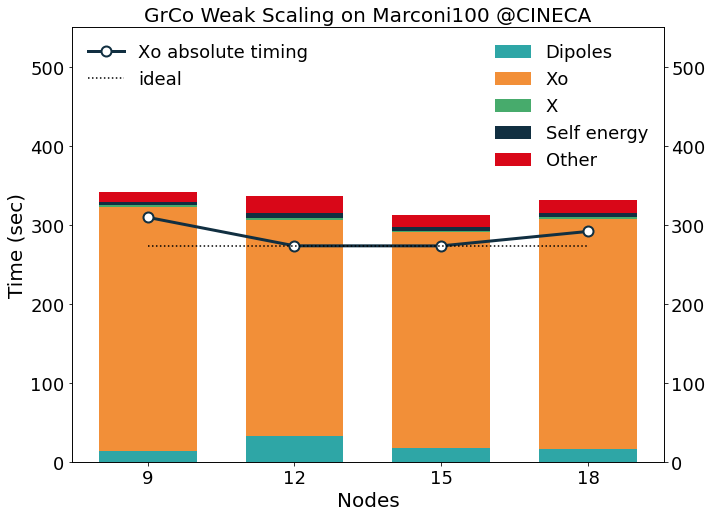

In [11]:
build_scaling_plot(scaling=scaling, x_axis='nodes', x_label='Nodes',
                   pile=pile, colors=colors, bar_width=2, Xo=True,
                   legend_loc='upper right', title=r'GrCo Weak Scaling on Marconi100 @CINECA', 
                   file_name='weakscaling.png', y_lim=[0,550])